In [11]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Imports
import pandas as pd
import numpy as np
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [52]:
# Defining some Globals
RANDOM_STATE = 42
NUM_FOLDS = 5
MIN_NUM_FEATURES = 10
TEST_SPLIT_PROPORTION=0.6
AGGRESSIVE=False
CATEGORICAL_FEATURE_COUNT=2

In [14]:
# Getting the Dataset
import pandas as pd
feat_info = pd.read_csv("/content/drive/My Drive/B Tech Project/DataSet 2018/Feat_info.csv", index_col="Feature Name", squeeze=True)
df = pd.read_csv("/content/drive/My Drive/B Tech Project/DataSet 2018/DDoS_2018.csv")
# Re-ordering the Columns to that in Feat_info.csv
df = pd.DataFrame(df, columns=feat_info.index)

In [15]:
# Categorical Columns need to be handled as well
# They include: Protocol, Dst Port and Label

df.loc[df["Protocol"] == 17, "Protocol"] = "UDP"
df.loc[df["Protocol"] == 6, "Protocol"] = "TCP"
df.loc[df["Protocol"] == 0, "Protocol"] = "HOPOPT"
protocol = pd.get_dummies(df["Protocol"], prefix="protocol")
df = pd.concat([df, protocol], axis=1)
df.drop("Protocol", axis=1, inplace=True)

df["protocol_HOPOPT"].astype("category")
df["protocol_UDP"].astype("category")
df["protocol_TCP"].astype("category")

# For Dst Port it is benign for all non-80 values
# So we can make the dataset more balanced by dropping
# the column itself so that the model is not biased on
# the basis of the port
df.drop("Dst Port", axis=1, inplace=True)

# Labels are: DDOS attack-HOIC (233961), Benign (126289), DDOS attack-LOIC-UDP (1211)
mapping = {"Benign": 0, "DDOS attack-HOIC": 1, "DDOS attack-LOIC-UDP": 2}
df["Label"] = df["Label"].apply(lambda label: mapping[label])

In [16]:
# Removing Timestamp
df.drop(columns=["Timestamp"], inplace=True)

In [17]:
# Stratification of DataSet
# Feature reduction will be done on the training dataset only
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["Label"]), df["Label"], test_size=TEST_SPLIT_PROPORTION, stratify=df["Label"], random_state=RANDOM_STATE)

# df -> Training Dataset
# test -> Testing Dataset
df = pd.concat([X_train, y_train], axis=1)
df.reset_index(drop=True, inplace=True)

test = pd.concat([X_train, y_train], axis=1)
test.reset_index(drop=True, inplace=True)

In [18]:
myModel=GaussianNB()
myModel.fit(df.drop(columns=["Label"]), df["Label"])
pred=myModel.predict(test.drop(columns=["Label"]))
print(classification_report(test["Label"], pred, output_dict=True)["macro avg"])

{'precision': 0.9999875340010123, 'recall': 0.9999769047784014, 'f1-score': 0.999982218873098, 'support': 206549}


In [19]:
myModel=RandomForestClassifier()
myModel.fit(df.drop(columns=["Label"]), df["Label"])
pred=myModel.predict(test.drop(columns=["Label"]))
print(classification_report(test["Label"], pred, output_dict=True)["macro avg"])

{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 206549}


In [20]:
myModel=LinearSVC(dual=False)
myModel.fit(df.drop(columns=["Label"]), df["Label"])
pred=myModel.predict(test.drop(columns=["Label"]))
print(classification_report(test["Label"], pred, output_dict=True)["macro avg"])

{'precision': 0.9999700831687908, 'recall': 0.9999445714681633, 'f1-score': 0.9999573243427511, 'support': 206549}


In [41]:
# Removing columns with constant values
for column_name in df.columns:
    if df[column_name].nunique() == 1:
        df.drop(column_name, axis=1, inplace=True)

In [45]:
# Dividing the features into continuous and categorical features
continuous = []
count = pd.DataFrame(dtype=np.int64, columns=["Number of Values"])
for column_name in df.columns:
    if column_name != "Label":
        count.loc[column_name] = df[column_name].nunique()
        if df[column_name].nunique() != CATEGORICAL_FEATURE_COUNT:
            continuous.append(column_name)

In [46]:
# Standard Scaling all the Continuous Values
scaler = StandardScaler()
scaler.fit(df[continuous])
df[continuous] = scaler.transform(df[continuous])

In [53]:
myModel = GaussianNB()
NB_sfs = sfs(myModel, k_features=MIN_NUM_FEATURES + random.choice(range(1, 3)), forward=True, floating=False, verbose=2, scoring='f1_macro', cv=NUM_FOLDS, n_jobs=-1)
NB_sfs = NB_sfs.fit(df.drop(columns=["Label"]), df["Label"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:   10.9s finished

[2021-03-28 14:50:54] Features: 1/11 -- score: 0.9939489767843153[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   17.2s finished

[2021-03-28 14:51:12] Features: 2/11 -- score: 0.9998719629609021[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   17.7s finished

[2021-03-28 14:51:30] Features: 3/11 -- score: 0.9999253147839273[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  65 out o

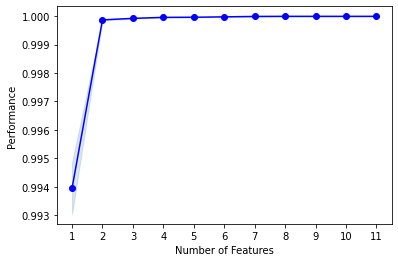

In [63]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(NB_sfs.get_metric_dict(), kind='std_err')

In [66]:
selected_features = NB_sfs.k_feature_idx_
selected_features = [feature_name for index, feature_name in enumerate(df.columns) if index in selected_features] 
print(selected_features)

['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Flow IAT Mean', 'Flow IAT Std', 'Fwd PSH Flags', 'Fwd Header Len', 'Bwd Pkts/s', 'Init Bwd Win Byts', 'Fwd Seg Size Min']


In [69]:
myModel=GaussianNB()
myModel.fit(pd.DataFrame(df, columns=selected_features), df["Label"])
pred=myModel.predict(pd.DataFrame(test, columns=selected_features))
print(classification_report(test["Label"], pred, output_dict=True)["macro avg"])

{'precision': 0.7835224659787938, 'recall': 0.6666791331318752, 'f1-score': 0.5064052372790675, 'support': 206549}


In [75]:
myModel = RandomForestClassifier(n_jobs=1)
RF_sfs = sfs(myModel, k_features=MIN_NUM_FEATURES + random.choice(range(1, 3)), forward=True, floating=False, verbose=2, scoring='f1_macro', cv=NUM_FOLDS, n_jobs=1)
RF_sfs = RF_sfs.fit(df.drop(columns=["Label"]), df["Label"])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [86]:
from itertools import combinations
num_features = MIN_NUM_FEATURES + random.choice(range(1, 3))

features = list(df.columns)
features.remove("Label")

feature_subset = []
for i in range(1, num_features+1):
    max_score = -1
    for feature in features:
        myModel=RandomForestClassifier(n_jobs=-1)
        myModel.fit(pd.DataFrame(df, columns=feature_subset + [feature]), df["Label"])
        prediction=myModel.predict(pd.DataFrame(df, columns=feature_subset + [feature]))
        score=f1_score(df["Label"], prediction, average="macro")
        if max_score < score:
            best_feature=feature
            max_score=score

    feature_subset.append(feature)
    features.remove(feature)
    print(feature_subset)

print(feature_subset)

['protocol_UDP']


KeyboardInterrupt: ignored

IndexError: ignored

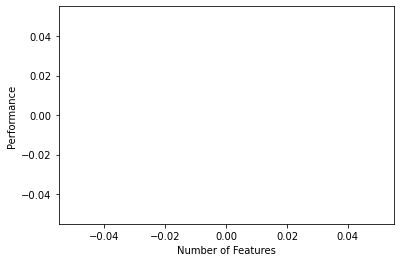

In [73]:
fig2 = plot_sfs(RF_sfs.get_metric_dict(), kind='std_err')

In [ ]:
myModel=RandomForestClassifier()
myModel.fit(pd.DataFrame(df, columns=selected_features), df["Label"])
pred=myModel.predict(pd.DataFrame(test, columns=selected_features))
print(classification_report(test["Label"], pred, output_dict=True)["macro avg"])

In [76]:
myModel = LinearSVC(dual=False)
SVC_sfs = sfs(myModel, k_features=MIN_NUM_FEATURES + random.choice(range(1, 3)), forward=True, floating=False, verbose=2, scoring='f1_macro', cv=NUM_FOLDS, n_jobs=-1)
SVC_sfs = SVC_sfs.fit(df.drop(columns=["Label"]), df["Label"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:   55.1s finished

[2021-03-28 16:08:56] Features: 1/11 -- score: 0.9970448854047265[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:  9.6min finished

[2021-03-28 16:18:32] Features: 2/11 -- score: 0.9983484145778657[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed: 14.4min finished

[2021-03-28 16:32:57] Features: 3/11 -- score: 0.9995685047657037[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  65 out o

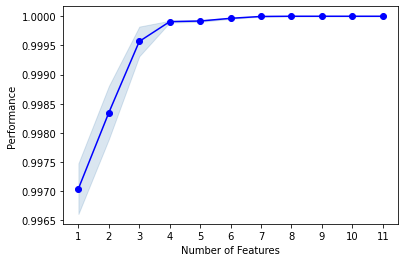

In [78]:
fig2 = plot_sfs(SVC_sfs.get_metric_dict(), kind='std_err')

In [83]:
selected_features = SVC_sfs.k_feature_idx_
selected_features = [feature_name for index, feature_name in enumerate(df.columns) if index in selected_features] 
print(selected_features)

['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Flow IAT Mean', 'Bwd Pkts/s', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Seg Size Min']


In [84]:
myModel=LinearSVC(dual=False)
myModel.fit(pd.DataFrame(df, columns=selected_features), df["Label"])
pred=myModel.predict(pd.DataFrame(test, columns=selected_features))
print(classification_report(test["Label"], pred, output_dict=True)["macro avg"])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'precision': 0.3536464200029961, 'recall': 0.3355586100701522, 'f1-score': 0.2672658914337105, 'support': 206549}
